In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import random

from scipy.sparse import csr_matrix

%load_ext rpy2.ipython

## Classic basic processing

In [2]:
# Load data: converted anndata from seurat obj via celloracle
adata = sc.read('../celloracle/cdk8.19_mouse_seurat_CO_notebook.h5ad')
# In this notebook, I use raw mRNA count as an input of Oracle object.
adata.X = adata.layers["raw_count"].copy()

In [3]:
# mark mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# cosmetical changes
adata.obs['cell_type_condition'] = adata.obs['predicted.CellTypes'].str.cat(adata.obs['condition'], sep="_")

In [4]:
#csr_matrix(adata.layers['raw_count'], dtype=np.float32).toarray()[:10, :10]
#checked if there're raw counts. And yep

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)

In [6]:
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape)

#Some genes were removed, not cells

(31447, 32285)
(31447, 26193)


In [7]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
#New layer for transformed data
adata.layers["norm_log1p"] = adata.X.copy()

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="orig.ident")

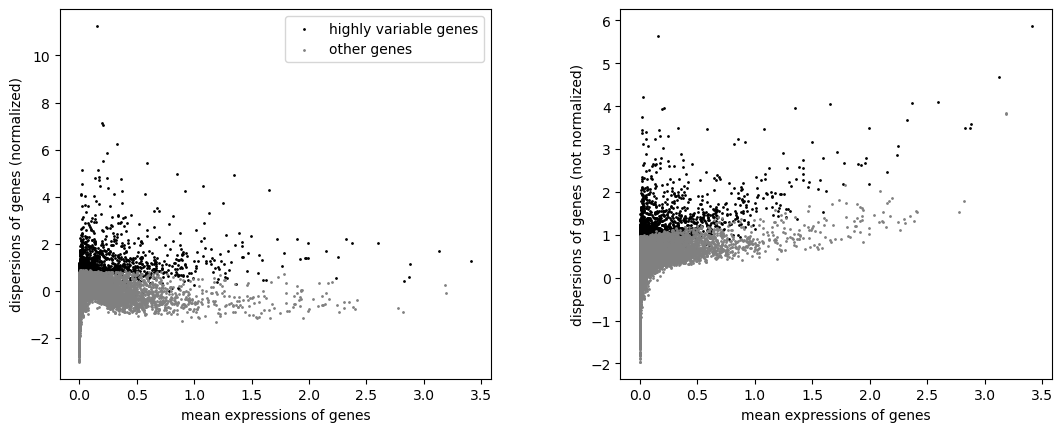

In [9]:
sc.pl.highly_variable_genes(adata)

In [10]:
sc.pp.scale(adata) # z-score
sc.tl.pca(adata)

In [11]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

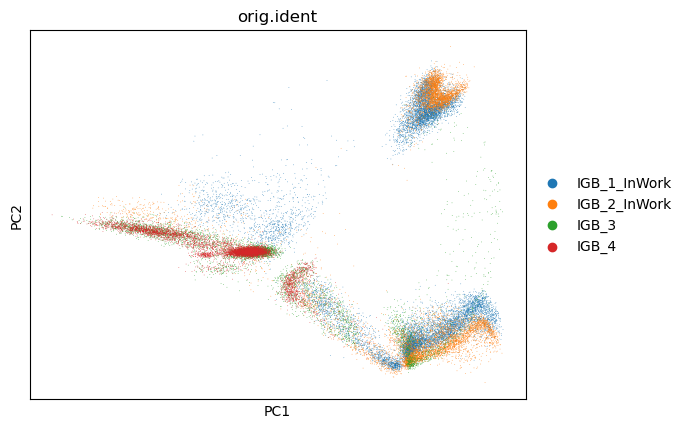

In [12]:
sc.pl.pca(
    adata,
    color=["orig.ident"], #orig.indent - samples feature
    dimensions=[(0, 1)],
    ncols=1,
    size=1,
)

In [13]:
# Run Harmony to correct PCA
sc.external.pp.harmony_integrate(adata, key='orig.ident', max_iter_harmony=20) #correction of batch effect

2025-03-28 11:08:18,392 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-28 11:08:41,401 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-28 11:08:41,741 - harmonypy - INFO - Iteration 1 of 20
2025-03-28 11:09:01,565 - harmonypy - INFO - Iteration 2 of 20
2025-03-28 11:09:22,847 - harmonypy - INFO - Iteration 3 of 20
2025-03-28 11:09:43,316 - harmonypy - INFO - Iteration 4 of 20
2025-03-28 11:10:03,474 - harmonypy - INFO - Iteration 5 of 20
2025-03-28 11:10:19,580 - harmonypy - INFO - Iteration 6 of 20
2025-03-28 11:10:27,438 - harmonypy - INFO - Iteration 7 of 20
2025-03-28 11:10:34,596 - harmonypy - INFO - Iteration 8 of 20
2025-03-28 11:10:41,003 - harmonypy - INFO - Converged after 8 iterations


In [14]:
# Calculate kNN graph
sc.pp.neighbors(adata, n_pcs=40, use_rep='X_pca_harmony')

# Calculate leiden clusters
sc.tl.leiden(adata)

# Calculate UMAP
sc.tl.umap(adata)

/tmp/ipykernel_1419638/403468874.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


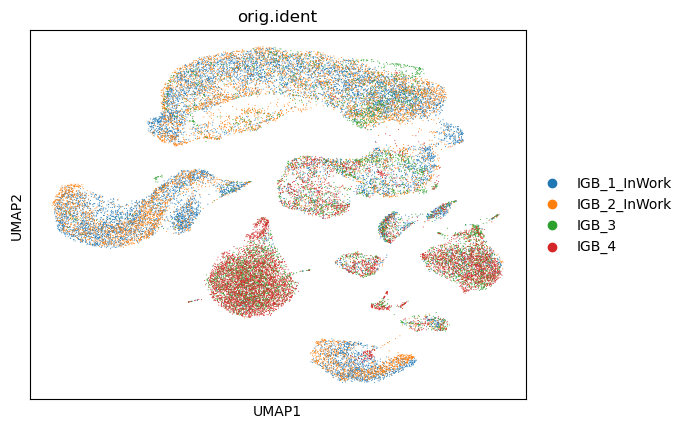

In [15]:
sc.pl.umap(
    adata,
    color="orig.ident",
    size=2,
)

In [16]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

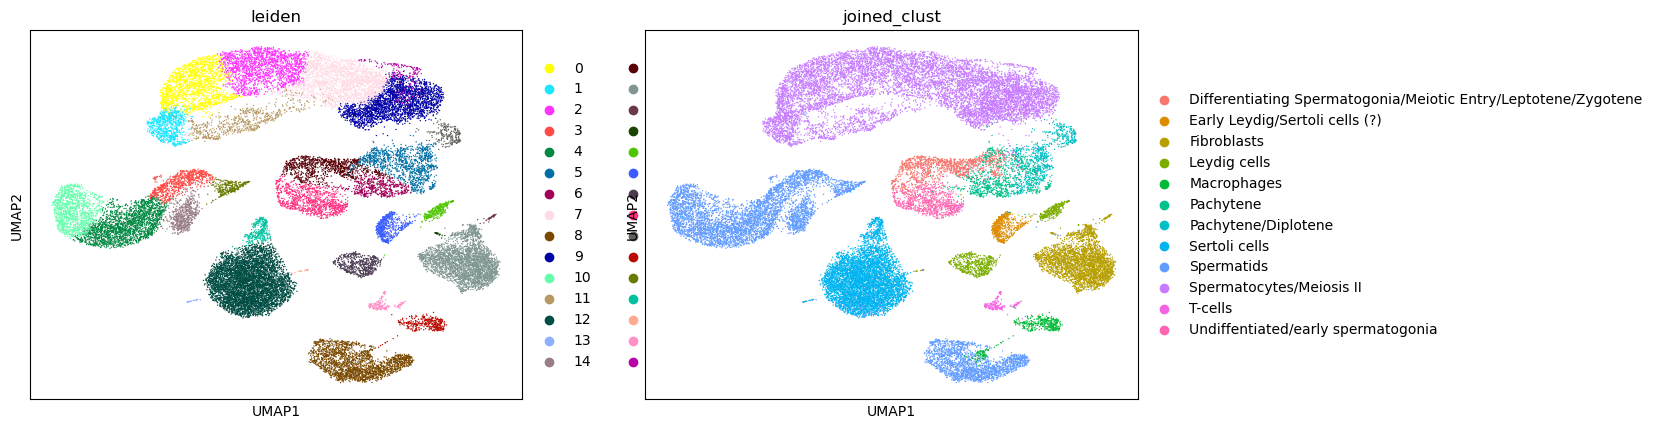

In [17]:
sc.pl.umap(adata, color=["leiden", "joined_clust"])

In [18]:
# Ensure Scanpy outputs two separate subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First UMAP (condition)
sc.pl.umap(adata, color="condition", ax=axes[0], show=False)
axes[0].set_title("Condition", fontsize=14)

# Second UMAP (predicted.CellTypes) with a new title
sc.pl.umap(adata, color="joined_clust", ax=axes[1], show=False)
axes[1].set_title("Cell types", fontsize=14)

plt.tight_layout()
plt.show()

## Fixed pseudobulk analysis

In [19]:
import decoupler as dc

# DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

import pydeseq2

In [20]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='orig.ident', #== sample
    groups_col='joined_clust', #==cell type
    layer='raw_count',
    mode='sum', #default
    min_cells=10, #filtration
    min_counts=100 #filtration
)

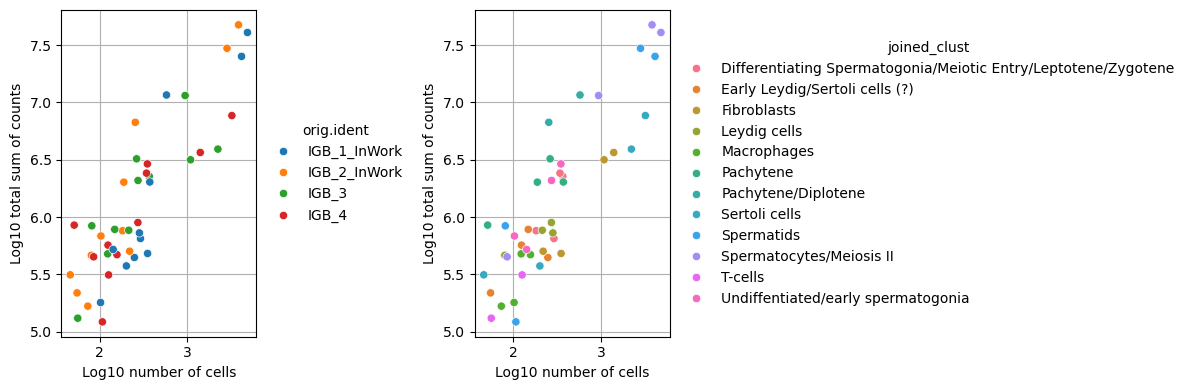

In [21]:
dc.plot_psbulk_samples(pdata, groupby=['orig.ident', 'joined_clust'], figsize=(12, 4))

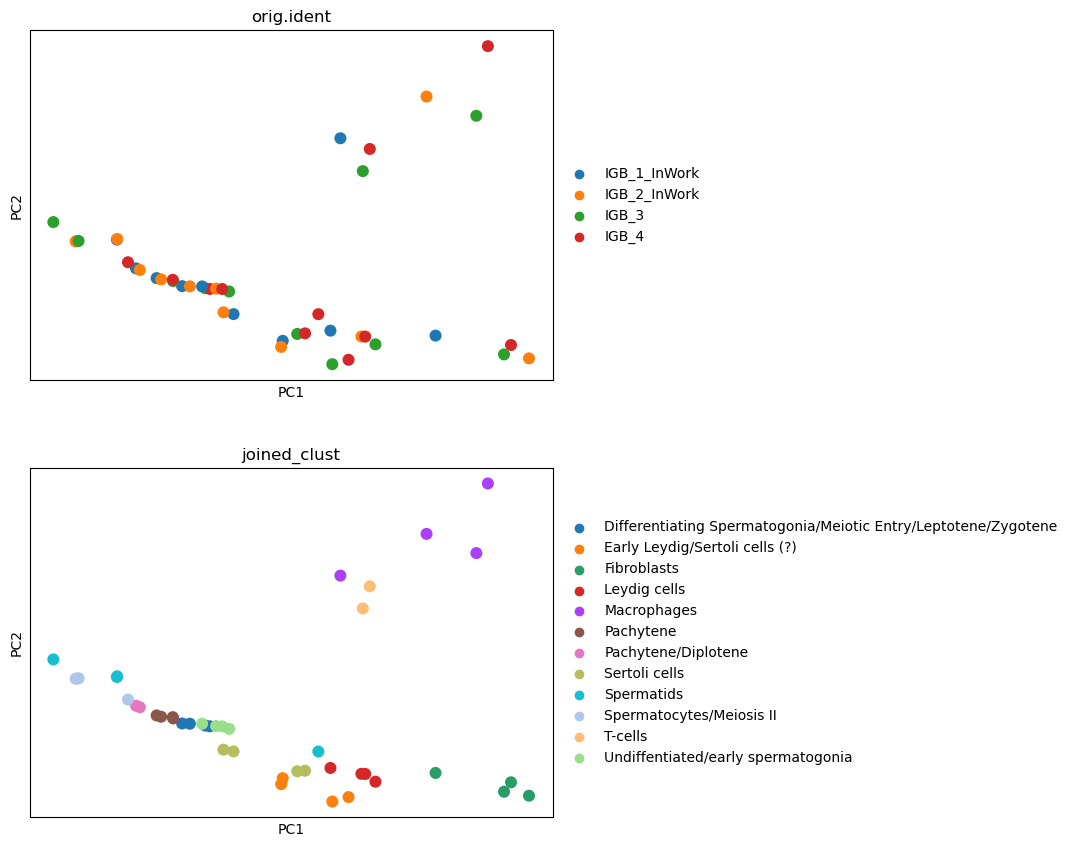

In [22]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

sc.pl.pca(pdata, color=['orig.ident', 'joined_clust'], ncols=1, size=300)
#We see distribution of samples on PCA according to cell types, not samples 

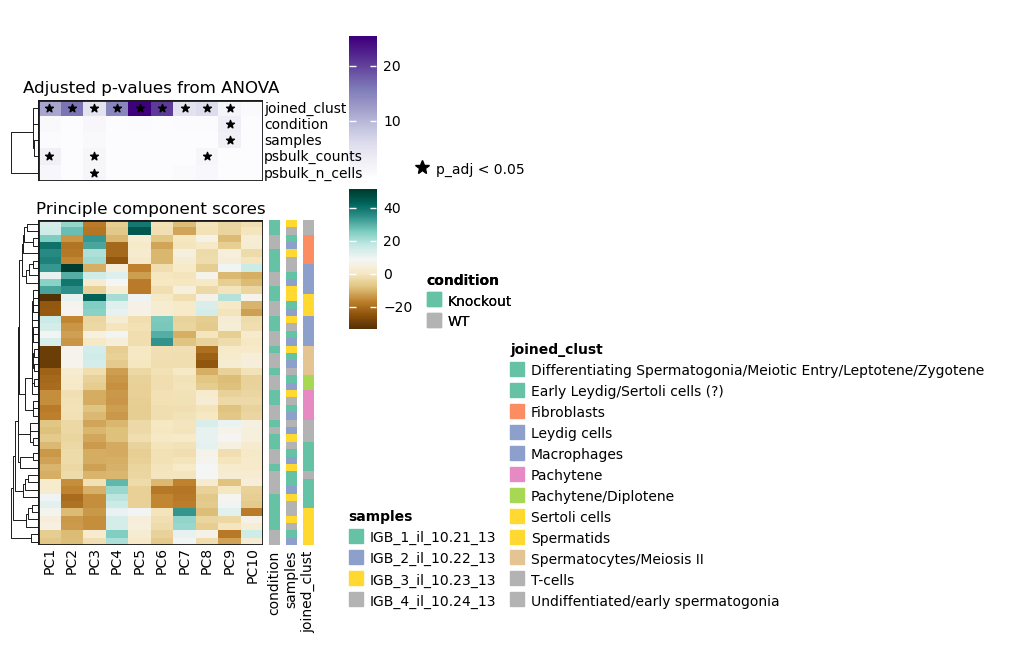

In [23]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['samples', 'condition', 'joined_clust', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'samples', 'joined_clust'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

#Meaning: PCA separates cell types, not condition

In [24]:
bulk = pd.read_csv('DEGs_from_bulkRNAseq.csv') #for intersection

set(pdata.obs['joined_clust'])

#Because python doesn't like special symbols
pdata.obs['joined_clust'] = pdata.obs['joined_clust'].astype(str)
pdata.obs.loc[pdata.obs['joined_clust'] == 'Early Leydig/Sertoli cells (?)', 'joined_clust'] = 'Early Leydig_or_Sertoli_maybe'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene', 'joined_clust'] = 'Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Pachytene/Diplotene', 'joined_clust'] = 'Pachytene_or_Diplotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Spermatocytes/Meiosis II', 'joined_clust'] = 'Spermatocytes_or_Meiosis_II'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Undiffentiated/early spermatogonia', 'joined_clust'] = 'Undiffentiated_or_early_spermatogonia'

In [53]:
def full_pseudobulk(pdata, i, min_count, min_total_count): #where i - cell type annotation 
    cell_type = pdata[pdata.obs['joined_clust'] == i].copy()
    genes = dc.filter_by_expr(cell_type, group='condition', min_count=min_count, min_total_count=min_total_count)
    
    # Filter by these genes
    cell_type = cell_type[:, genes].copy()
    # Build DESeq2 object
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(     # create an object
        counts=cell_type.X, #raw counts
        metadata=cell_type.obs,
        design='~condition',
        refit_cooks=True,
        inference=inference,
        quiet=True)

    if 'Knockout' not in set(dds.obs['condition']) or 'WT' not in set(dds.obs['condition']):
        print('There is no KO or WT samples for this cell type')
        print(dds.obs['condition'])
        return None
    
    # Compute LFCs
    dds.deseq2()
    # Extract contrast between KO and WT
    ds_KO_vs_WT = DeseqStats(
        dds,
        contrast=["condition", 'Knockout', 'WT'],
        inference=inference,
        quiet=True
    )
    # Compute Wald test
    ds_KO_vs_WT.summary()
    #ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
    results_df = ds_KO_vs_WT.results_df
    results_df.index = cell_type.var.index
    
    plot = dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
        figsize=(8, 4)
    )
    # significant = results_df[abs(results_df['padj']) < 0.05]
    # singlecell = significant.index
    # sc_bulk_intersection = list(set(singlecell) & set(bulk['x']))
    return plot

In [30]:
set(pdata.obs['joined_clust'])

{'Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene',
 'Early Leydig_or_Sertoli_maybe',
 'Fibroblasts',
 'Leydig cells',
 'Macrophages',
 'Pachytene',
 'Pachytene_or_Diplotene',
 'Sertoli cells',
 'Spermatids',
 'Spermatocytes_or_Meiosis_II',
 'T-cells',
 'Undiffentiated_or_early_spermatogonia'}

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


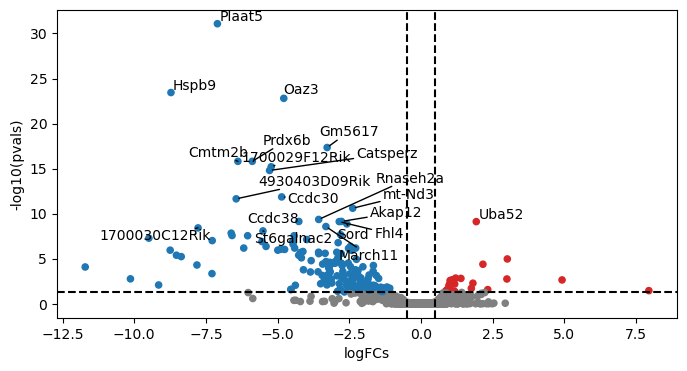

In [54]:
full_pseudobulk(pdata, 'Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene', 45, 60)

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


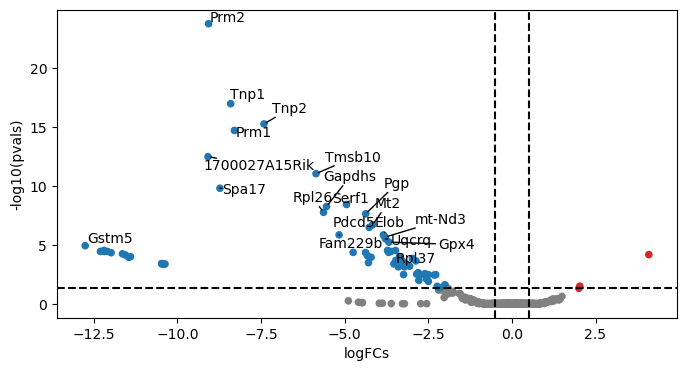

In [76]:
full_pseudobulk(pdata, 'Early Leydig_or_Sertoli_maybe', 100, 150)

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


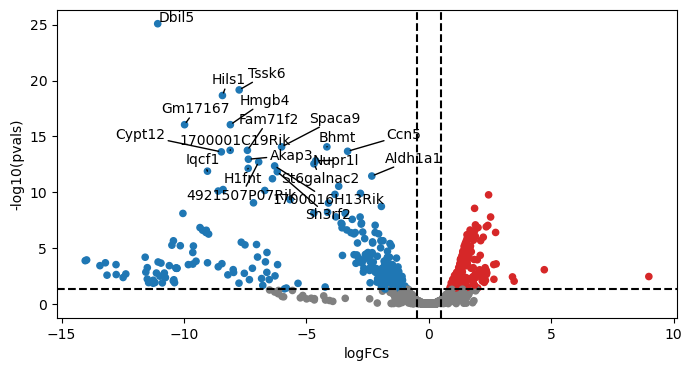

In [56]:
full_pseudobulk(pdata, 'Fibroblasts', 50, 65)

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


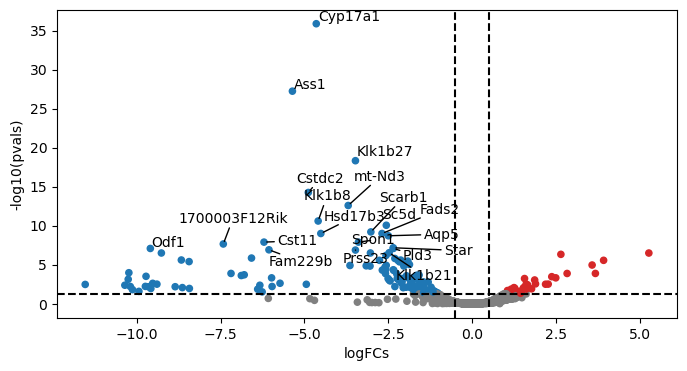

In [66]:
full_pseudobulk(pdata, 'Leydig cells', 45, 55)

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


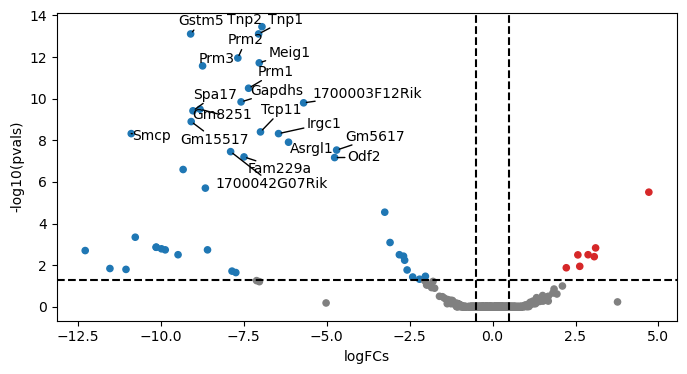

In [73]:
full_pseudobulk(pdata, 'Macrophages', 55, 75)

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


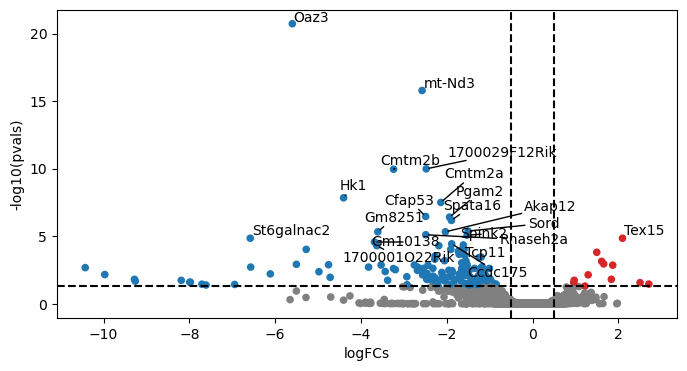

In [59]:
full_pseudobulk(pdata, 'Pachytene', 30, 45)

In [48]:
full_pseudobulk(pdata, 'Pachytene_or_Diplotene', 10, 15)

There is no KO or WT samples for this cell type
IGB_1_InWork_Pachytene/Diplotene    WT
IGB_2_InWork_Pachytene/Diplotene    WT
Name: condition, dtype: category
Categories (1, object): ['WT']


/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


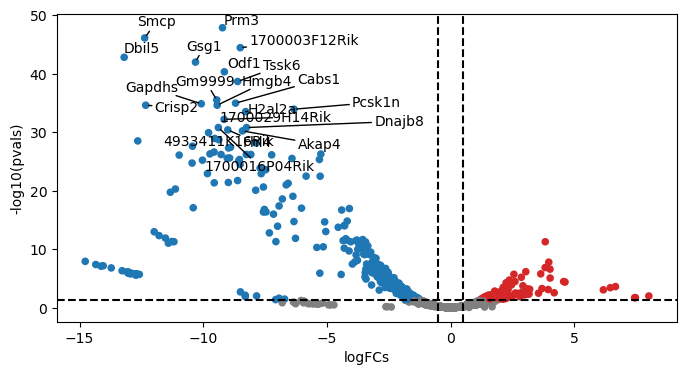

In [78]:
full_pseudobulk(pdata, 'Sertoli cells', 100, 105)

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


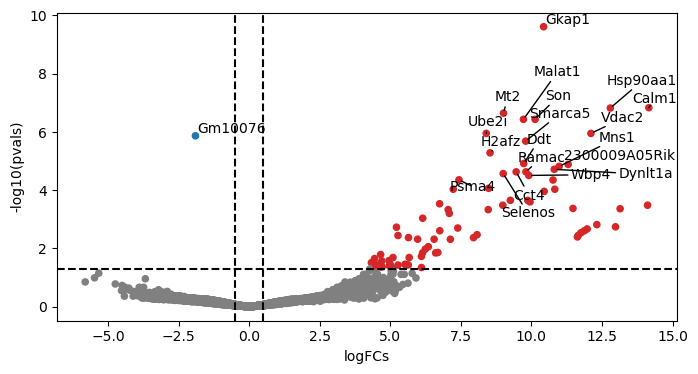

In [69]:
full_pseudobulk(pdata, 'Spermatids', 40, 55)

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


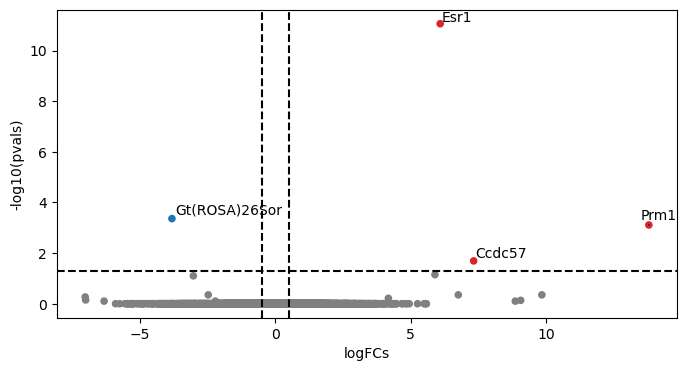

In [62]:
full_pseudobulk(pdata, 'Spermatocytes_or_Meiosis_II', 10, 15)

In [63]:
full_pseudobulk(pdata, 'T-cells', 10, 20)

There is no KO or WT samples for this cell type
IGB_3_T-cells    Knockout
IGB_4_T-cells    Knockout
Name: condition, dtype: category
Categories (1, object): ['Knockout']


/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


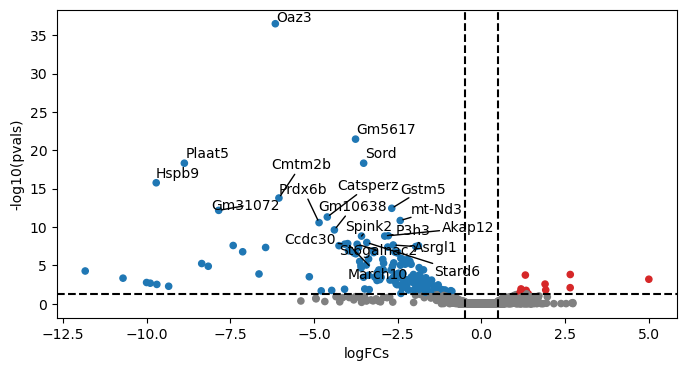

In [75]:
full_pseudobulk(pdata, 'Undiffentiated_or_early_spermatogonia', 45, 55)

In [93]:
# # Extract matrix and row names
# normed_counts = dds.layers['normed_counts']
# rownames = dds.obs['orig.ident']
# colnames = cell_type.var.index

# #pd.set_option('display.max_columns', None) 
# # Convert to DataFrame
# pd.DataFrame(normed_counts, index=rownames, columns=colnames)['Ass1']

orig.ident
IGB_1_InWork    378.698296
IGB_2_InWork    547.335096
IGB_3            14.375268
IGB_4             8.132516
Name: Ass1, dtype: float64

## Check distribution of counts ~condition

In [101]:
for i in set(pdata.obs['joined_clust']):
    cell = pdata[pdata.obs['joined_clust'] == i].copy()
    print('sum of counts for ', i )
    print(pdata.obs[pdata.obs['joined_clust'] == i]['condition'])
    print(np.sum(cell.X, axis=1))

#Обычно для ингибирования каунтов больше, но есть типы клеток, где меньше. Вроде как, как раз те, где клетки умирали из-за ингибирования: сперматиды и пр.

sum of counts for  Early Leydig_or_Sertoli_maybe
IGB_1_InWork_Early Leydig/Sertoli cells (?)          WT
IGB_2_InWork_Early Leydig/Sertoli cells (?)          WT
IGB_3_Early Leydig/Sertoli cells (?)           Knockout
IGB_4_Early Leydig/Sertoli cells (?)           Knockout
Name: condition, dtype: category
Categories (2, object): ['Knockout', 'WT']
[444607. 218306. 781899. 569804.]
sum of counts for  Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene
IGB_1_InWork_Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene          WT
IGB_2_InWork_Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene          WT
IGB_3_Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene           Knockout
IGB_4_Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene           Knockout
Name: condition, dtype: category
Categories (2, object): ['Knockout', 'WT']
[ 650683.  761314. 2265390. 2418926.]
sum of counts for  Fibroblasts
IGB_1_InWork_Fibroblasts     

In [94]:
fibroblasts = pdata[pdata.obs['joined_clust'] == 'Fibroblasts'].copy()
fibroblasts.obs

orig.ident joined_clust seurat_clusters  \
IGB_1_InWork_Fibroblasts  IGB_1_InWork  Fibroblasts               4   
IGB_2_InWork_Fibroblasts  IGB_2_InWork  Fibroblasts               4   
IGB_3_Fibroblasts                IGB_3  Fibroblasts               4   
IGB_4_Fibroblasts                IGB_4  Fibroblasts               4   

                                    samples condition  \
IGB_1_InWork_Fibroblasts  IGB_1_il_10.21_13        WT   
IGB_2_InWork_Fibroblasts  IGB_2_il_10.22_13        WT   
IGB_3_Fibroblasts         IGB_3_il_10.23_13  Knockout   
IGB_4_Fibroblasts         IGB_4_il_10.24_13  Knockout   

                         nCount_prediction.score.CellTypes  \
IGB_1_InWork_Fibroblasts                                 0   
IGB_2_InWork_Fibroblasts                                 0   
IGB_3_Fibroblasts                                        0   
IGB_4_Fibroblasts                                        0   

                         nFeature_prediction.score.CellTypes active_ident  \
IGB_1_InWork_Fibroblasts                                   0  Fibroblasts   
IGB_2_InWork_Fibroblasts                                   0  Fibroblasts   
IGB_3_Fibroblasts                                          0  Fibroblasts   
IGB_4_Fibroblasts                                          0  Fibroblasts   

                          psbulk_n_cells  psbulk_counts  
IGB_1_InWork_Fibroblasts           351.0       482121.0  
IGB_2_InWork_Fibroblasts           219.0       504130.0  
IGB_3_Fibroblasts                 1086.0      3164315.0  
IGB_4_Fibroblasts                 1401.0      3663479.0

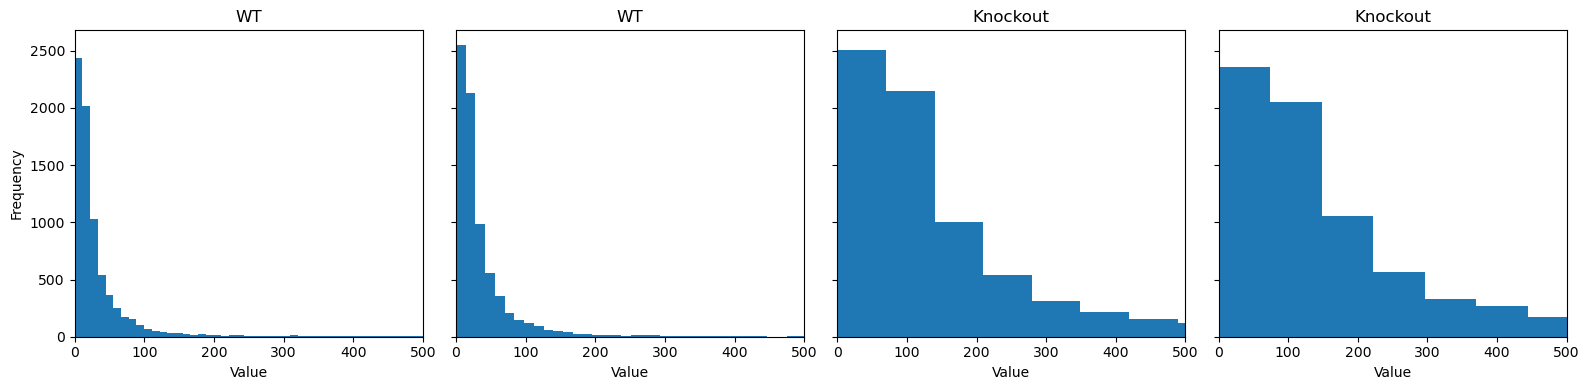

In [96]:
#Get only fibroblasts
fibroblasts = pdata[pdata.obs['joined_clust'] == 'Fibroblasts'].copy()

fibroblasts = fibroblasts[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(fibroblasts.X[i], bins=2000)

    ax.set_title(fibroblasts.obs['condition'][i])
    ax.set_xlabel('Value')
    ax.set_xlim([0, 500])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

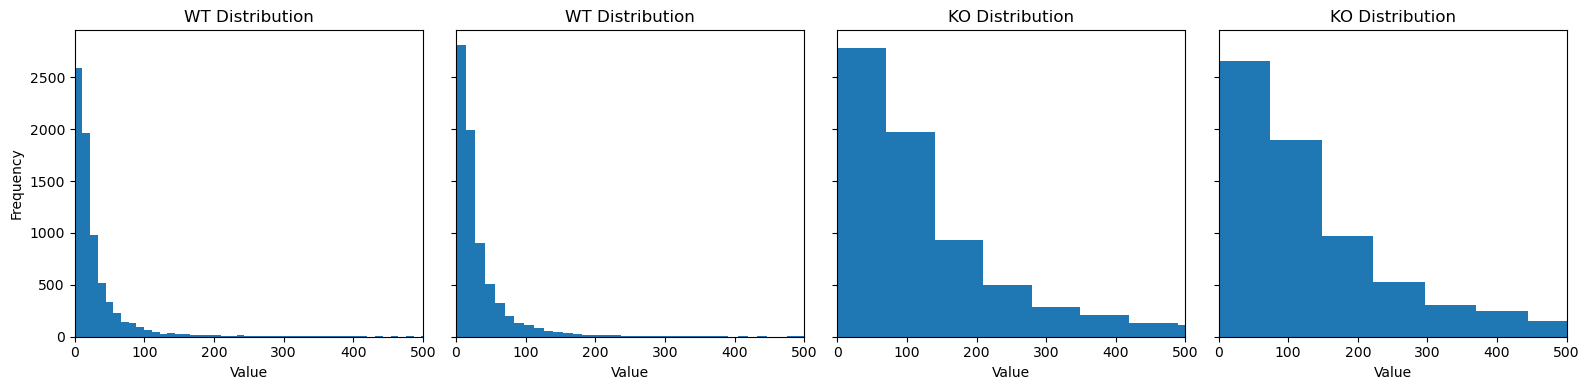

In [64]:
#Get only fibroblasts
fibroblasts = pdata[pdata.obs['joined_clust'] == 'Fibroblasts'].copy()

fibroblasts = fibroblasts[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(fibroblasts.X[i], bins=2000)

    if i == 0 or i == 1:
        ax.set_title(f'WT Distribution')
    else: 
        ax.set_title(f'KO Distribution')
    ax.set_xlabel('Value')
    ax.set_xlim([0, 500])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

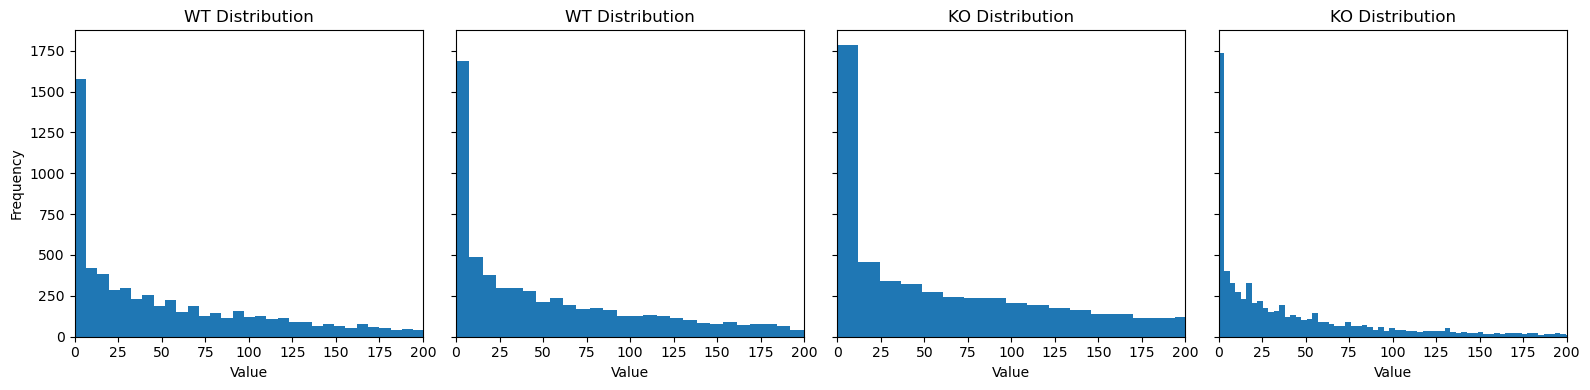

In [68]:
#Get only agranulocytes
pachytene = pdata[pdata.obs['joined_clust'] == 'Pachytene'].copy()

pachytene = pachytene[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(pachytene.X[i], bins=2000)
    if i == 0 or i == 1:
        ax.set_title(f'WT Distribution')
    else: 
        ax.set_title(f'KO Distribution')
    ax.set_xlabel('Value')
    ax.set_xlim([0, 200])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

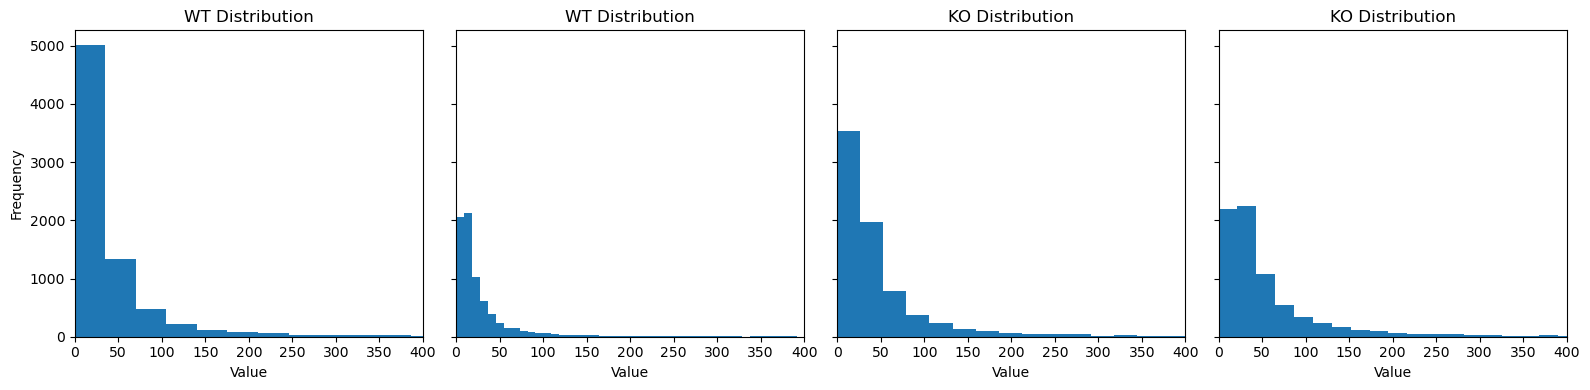

In [67]:
#Get only Leydig cells
leydig = pdata[pdata.obs['joined_clust'] == 'Leydig cells'].copy()
genes = dc.filter_by_expr(leydig, group='condition', min_count=10, min_total_count=15)

# Filter by these genes
leydig = leydig[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(leydig.X[i], bins=2000)
    if i == 0 or i == 1:
        ax.set_title(f'WT Distribution')
    else: 
        ax.set_title(f'KO Distribution')
    ax.set_xlabel('Value')
    ax.set_xlim([0, 400])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [327]:
import decoupler as dc

# DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [328]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='orig.ident', #== sample
    groups_col='joined_clust', #==cell type
    layer='raw_count',
    mode='mean',
    min_cells=10, #filtration
    min_counts=100 #filtration
)

#Because python doesn't like special symbols
pdata.obs['joined_clust'] = pdata.obs['joined_clust'].astype(str)
pdata.obs.loc[pdata.obs['joined_clust'] == 'Early Leydig/Sertoli cells (?)', 'joined_clust'] = 'Early Leydig_or_Sertoli_maybe'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene', 'joined_clust'] = 'Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Pachytene/Diplotene', 'joined_clust'] = 'Pachytene_or_Diplotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Spermatocytes/Meiosis II', 'joined_clust'] = 'Spermatocytes_or_Meiosis_II'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Undiffentiated/early spermatogonia', 'joined_clust'] = 'Undiffentiated_or_early_spermatogonia'


In [331]:
pdata.X

array([[0.0000000e+00, 0.0000000e+00, 5.4982819e-02, ..., 5.2783504e+00,
        2.8419244e+00, 6.7010307e-01],
       [5.4945056e-03, 0.0000000e+00, 1.7032968e-01, ..., 1.0412087e+01,
        5.2802196e+00, 7.1428573e-01],
       [1.0899182e-02, 0.0000000e+00, 2.4523161e-01, ..., 1.9956404e+01,
        8.0844688e+00, 1.4005450e+00],
       ...,
       [2.9126214e-02, 0.0000000e+00, 2.7184466e-01, ..., 1.1834951e+01,
        6.3009710e+00, 7.1844661e-01],
       [7.3260074e-03, 0.0000000e+00, 2.2710623e-01, ..., 2.1315018e+01,
        9.1941395e+00, 1.2197802e+00],
       [2.8653296e-03, 0.0000000e+00, 3.5816619e-01, ..., 1.6074499e+01,
        7.6246419e+00, 1.1146132e+00]], dtype=float32)

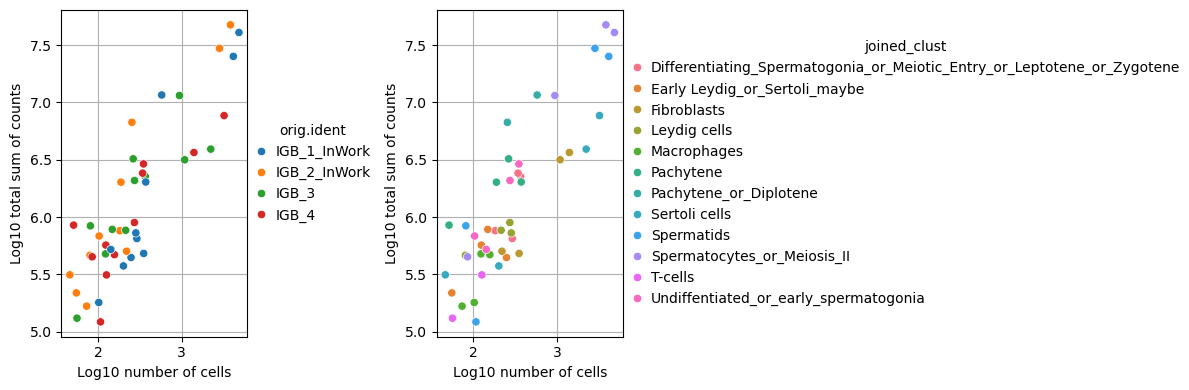

In [332]:
dc.plot_psbulk_samples(pdata, groupby=['orig.ident', 'joined_clust'], figsize=(12, 4))

In [333]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

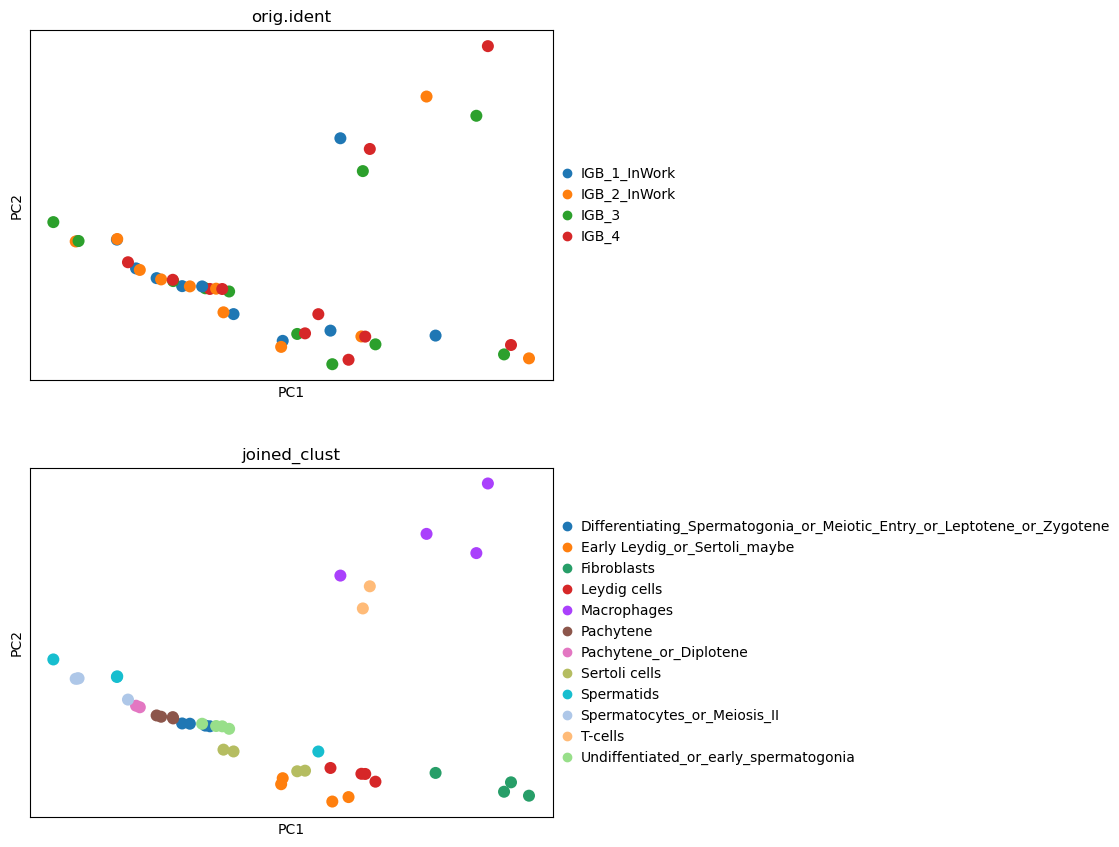

In [334]:
sc.pl.pca(pdata, color=['orig.ident', 'joined_clust'], ncols=1, size=300)
#We see distribution of samples on PCA according to cell types, not samples 

In [335]:
pdata.X

array([[0.0000000e+00, 0.0000000e+00, 5.4982819e-02, ..., 5.2783504e+00,
        2.8419244e+00, 6.7010307e-01],
       [5.4945056e-03, 0.0000000e+00, 1.7032968e-01, ..., 1.0412087e+01,
        5.2802196e+00, 7.1428573e-01],
       [1.0899182e-02, 0.0000000e+00, 2.4523161e-01, ..., 1.9956404e+01,
        8.0844688e+00, 1.4005450e+00],
       ...,
       [2.9126214e-02, 0.0000000e+00, 2.7184466e-01, ..., 1.1834951e+01,
        6.3009710e+00, 7.1844661e-01],
       [7.3260074e-03, 0.0000000e+00, 2.2710623e-01, ..., 2.1315018e+01,
        9.1941395e+00, 1.2197802e+00],
       [2.8653296e-03, 0.0000000e+00, 3.5816619e-01, ..., 1.6074499e+01,
        7.6246419e+00, 1.1146132e+00]], dtype=float32)

In [336]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['samples', 'condition', 'joined_clust', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

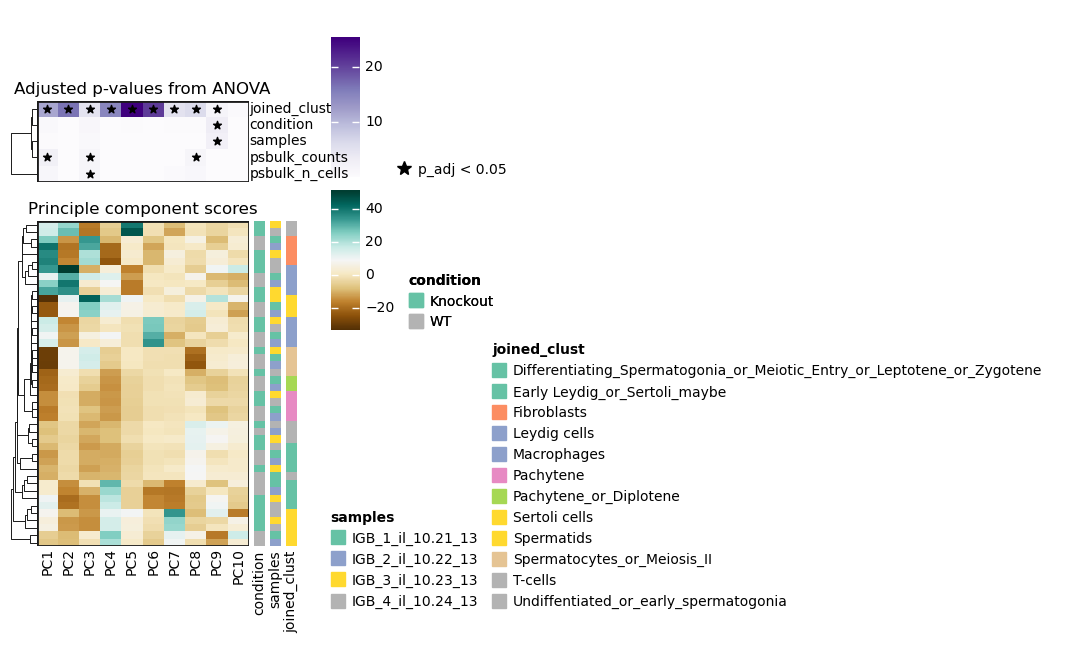

In [337]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'samples', 'joined_clust'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

#Meaning: PCA separates cell types, not condition

In [338]:
bulk = pd.read_csv('DEGs_from_bulkRNAseq.csv')

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.03 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Using None as control genes, passed at DeseqDataSet initialization


Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...
... done in 0.04 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     7.191546        0.841571  0.881145  0.955089  0.339533  0.950470
1     9.124206       -0.085309  0.798793 -0.106797  0.914950  0.963105
2    24.793904        0.224039  0.562197  0.398506  0.690257  0.950470
3     7.795417       -0.015059  0.835098 -0.018033  0.985612  0.985612
4   169.647220       -0.089474  0.451227 -0.198290  0.842818  0.950470
5    20.117214       -6.800780  1.583834 -4.293871  0.000018  0.000176
6     8.749322       -7.039029  2.478247 -2.840326  0.004507  0.030045
7    15.938521        0.829493  0.654865  1.266662  0.205276  0.821104
8     9.201918        0.412730  0.795423  0.518881  0.603844  0.950470
9    85.318795        0.148278  0.432873  0.342545  0.731941  0.950470
10  134.266229       -0.522559  0.407653 -1.281872  0.199888  0.821104
11   99.448816       -0.077612  0.425962 -0.182203  0.855423  0.950470
12  141.308707

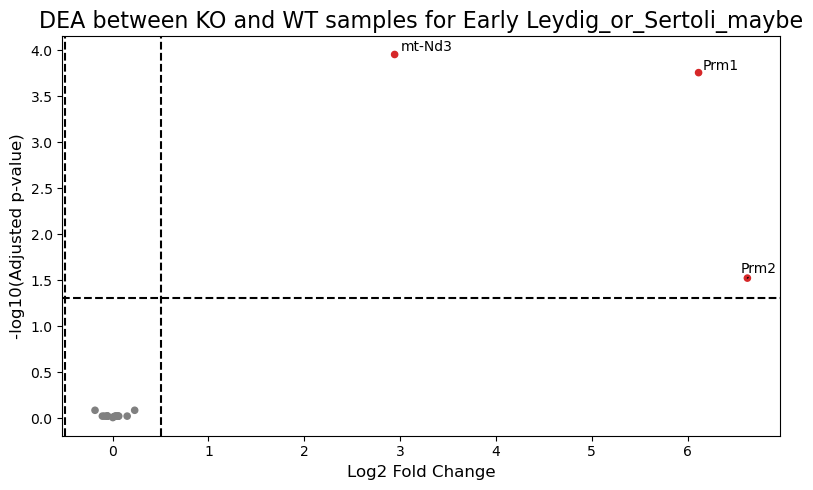

significantly DE genes for  Early Leydig_or_Sertoli_maybe , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.16 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    8.212384       -0.709628  0.606913 -1.169243  0.242306  0.775397
1    9.598135       -0.174430  0.581069 -0.300188  0.764034  0.899938
2    9.917702       -0.076646  0.573434 -0.133662  0.893670  0.932525
3   18.419419       -1.258505  0.606722 -2.074270  0.038054  0.590108
4   10.457649       -0.027384  0.561246 -0.048791  0.961086  0.977330
5   13.224611       -0.570145  0.514536 -1.108075  0.267829  0.775397
6   19.591470       -0.357577  0.457059 -0.782344  0.434013  0.886749
7   15.134260       -0.563906  0.495803 -1.137358  0.255389  0.775397
8   11.461187       -1.080334  0.549626 -1.965582  0.049347  0.590108
9    8.539202        0.317919  0.615800  0.516269  0.605666  0.899938
10  14.239813        0.555509  0.525838  1.056426  0.290774  0.775397
11   8.241957        0.717791  0.652144  1.100664  0.271043  0.775397
12   9.324376        0.7582

... done in 0.18 seconds.



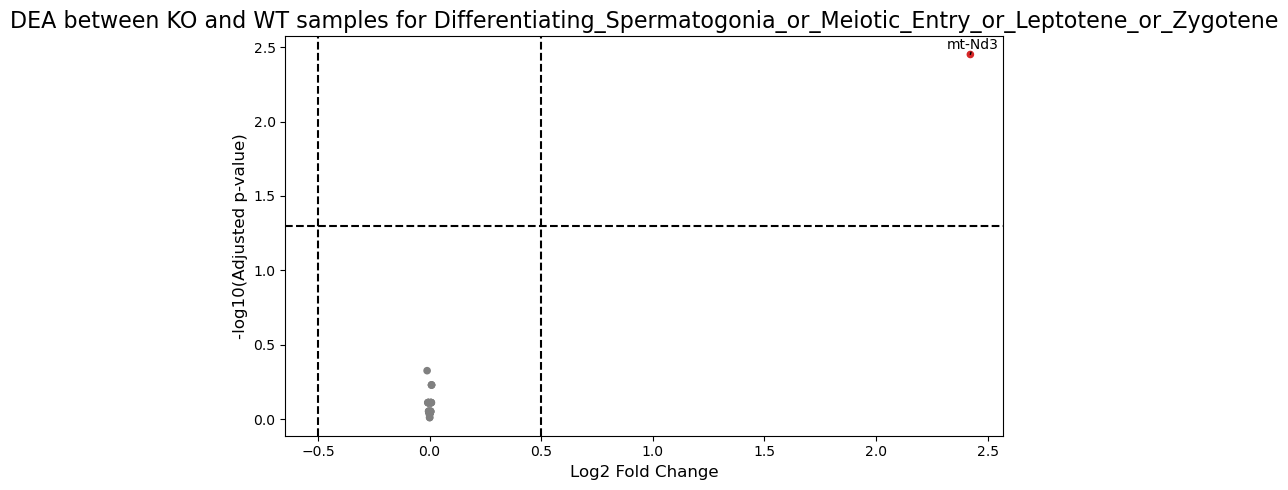

significantly DE genes for  Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.03 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.01 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     7.500723        1.374129  0.848849  1.618814  0.105487  0.497297
1     6.382590        0.345303  0.782298  0.441395  0.658927  0.869784
2    30.675068       -0.117135  0.533111 -0.219720  0.826090  0.940033
3     7.894502        0.202454  0.728436  0.277929  0.781067  0.920543
4     8.551598       -0.068845  0.701585 -0.098128  0.921831  0.950638
5    45.191402       -1.939307  0.562873 -3.445371  0.000570  0.009410
6    15.150975       -1.344920  0.610681 -2.202327  0.027642  0.182439
7    10.998366       -0.878772  0.649639 -1.352708  0.176149  0.597541
8   112.210320       -1.127531  0.464085 -2.429578  0.015116  0.166281
9    22.343677       -7.161440  1.577031 -4.541088  0.000006  0.000185
10    7.200631        0.631802  0.778779  0.811273  0.417209  0.764883
11    8.564447        0.673353  0.733793  0.917633  0.358811  0.764883
12    6.029582

... done in 0.10 seconds.



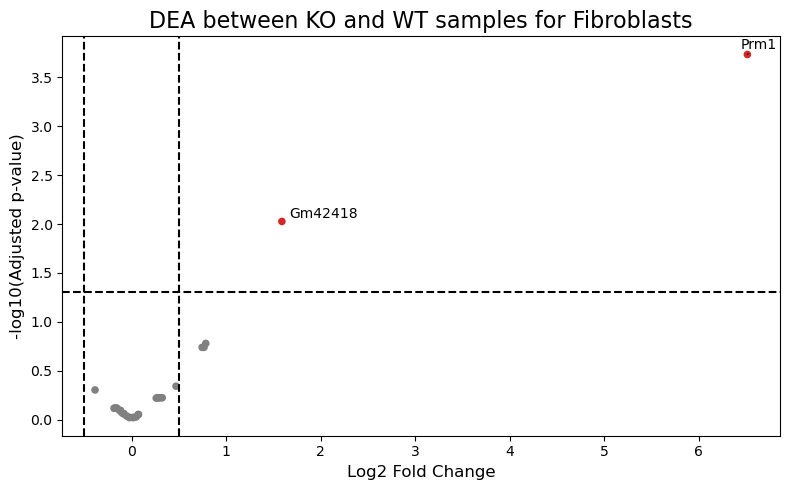

significantly DE genes for  Fibroblasts , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.11 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.03 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...


There is no KO or WT samples for this cell type
Using None as control genes, passed at DeseqDataSet initialization


... done in 0.13 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.07 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.03 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   10.106955       -0.218298  0.627245 -0.348026  0.727820  0.995475
1   10.720414       -0.189491  0.617039 -0.307097  0.758769  0.995475
2   11.431673       -0.354291  0.606133 -0.584510  0.558877  0.995475
3   12.928359       -0.169017  0.583766 -0.289529  0.772176  0.995475
4    8.901254       -0.278287  0.646483 -0.430463  0.666859  0.995475
..        ...             ...       ...       ...       ...       ...
84  22.893739       -0.241689  0.512324 -0.471752  0.637104  0.995475
85  15.621569       -0.156011  0.556369 -0.280410  0.779163  0.995475
86   9.063336       -2.602237  0.754482 -3.449039  0.000563  0.050070
87  18.853793       -0.231743  0.532679 -0.435052  0.663524  0.995475
88  13.095077        0.120545  0.586199  0.205639  0.837073  0.995475

[89 rows x 6 columns]


Fitting MAP LFCs...
... done in 0.39 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   10.106955    5.746433e-07  0.001354 -0.348026  0.727820  0.995475
1   10.720414    5.174238e-07  0.001356 -0.307097  0.758769  0.995475
2   11.431673    9.969067e-07  0.001375 -0.584510  0.558877  0.995475
3   12.928359    5.189351e-07  0.001367 -0.289529  0.772176  0.995475
4    8.901254    6.926379e-07  0.001359 -0.430463  0.666859  0.995475
..        ...             ...       ...       ...       ...       ...
84  22.893739    9.217689e-07  0.001405 -0.471752  0.637104  0.995475
85  15.621569    5.272976e-07  0.001373 -0.280410  0.779163  0.995475
86   9.063336    2.079536e+00  0.756909 -3.449039  0.000563  0.050070
87  18.853793    8.743511e-07  0.001392 -0.435052  0.663524  0.995475
88  13.095077   -3.627233e-07  0.001336  0.205639  0.837073  0.995475

[89 rows x 6 columns]


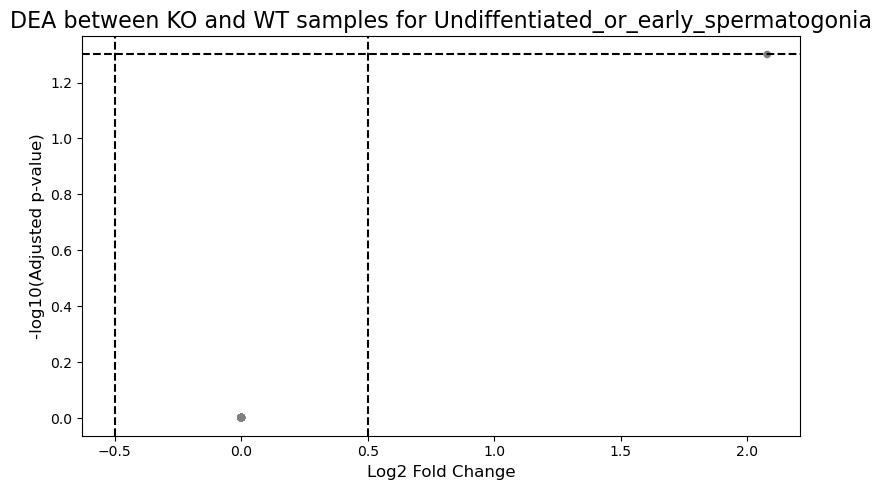

significantly DE genes for  Undiffentiated_or_early_spermatogonia , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.15 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.30 seconds.

Fitting LFCs...
... done in 0.12 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.04 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     9.337915        0.022985  0.771913  0.029777  0.976245  0.992602
1     8.473758       -0.077277  0.818709 -0.094389  0.924800  0.992602
2    11.071655       -0.137981  0.711531 -0.193921  0.846237  0.992602
3    12.107771        0.288753  0.678859  0.425351  0.670581  0.992602
4    12.987773        0.434464  0.656060  0.662233  0.507822  0.992602
..         ...             ...       ...       ...       ...       ...
145  22.937918       -0.128359  0.497340 -0.258090  0.796337  0.992602
146   9.489087        0.217699  0.787806  0.276335  0.782291  0.992602
147  15.094504       -0.121229  0.618479 -0.196011  0.844601  0.992602
148  11.495303       -0.045052  0.710280 -0.063428  0.949426  0.992602
149  13.341713        0.253353  0.671037  0.377554  0.705762  0.992602

[150 rows x 6 columns]


Fitting MAP LFCs...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
... done in 0.70 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     9.337915   -3.626587e-08  0.001477  0.029777  0.976245  0.992602
1     8.473758    1.216364e-07  0.001474 -0.094389  0.924800  0.992602
2    11.071655    2.863828e-07  0.001501 -0.193921  0.846237  0.992602
3    12.107771   -6.588830e-07  0.001432  0.425351  0.670581  0.992602
4    12.987773   -1.046199e-06  0.001410  0.662233  0.507822  0.992602
..         ...             ...       ...       ...       ...       ...
145  22.937918    5.450001e-07  0.001500 -0.258090  0.796337  0.992602
146   9.489087   -3.660397e-07  0.001456  0.276335  0.782291  0.992602
147  15.094504    3.324261e-07  0.001506 -0.196011  0.844601  0.992602
148  11.495303    9.997035e-08  0.001495 -0.063428  0.949426  0.992602
149  13.341713   -5.185892e-07  0.001447  0.377554  0.705762  0.992602

[150 rows x 6 columns]


significantly DE genes for  Spermatocytes_or_Meiosis_II , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.16 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.32 seconds.

Fitting LFCs...
... done in 0.15 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.06 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.085234        0.180261  0.668699  0.269570  0.787491  0.994438
1    11.823314        0.222149  0.662018  0.335564  0.737200  0.994438
2    16.953201       -0.129092  0.616728 -0.209318  0.834200  0.994438
3     9.443930        0.024983  0.697943  0.035795  0.971446  0.994438
4     9.033663       -0.735486  0.718402 -1.023781  0.305939  0.994438
..         ...             ...       ...       ...       ...       ...
168  20.699614        0.192030  0.589880  0.325542  0.744771  0.994438
169  22.756377        0.070673  0.590343  0.119715  0.904709  0.994438
170  10.591342       -2.666488  0.768678 -3.468928  0.000523  0.090399
171  22.962086        0.027496  0.577891  0.047580  0.962051  0.994438
172  16.883063        0.371888  0.617230  0.602511  0.546834  0.994438

[173 rows x 6 columns]


... done in 0.72 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.085234   -4.202402e-07  0.001331  0.269570  0.787491  0.994438
1    11.823314   -5.289058e-07  0.001330  0.335564  0.737200  0.994438
2    16.953201    3.540612e-07  0.001383 -0.209318  0.834200  0.994438
3     9.443930   -6.555341e-08  0.001341  0.035795  0.971446  0.994438
4     9.033663    1.452790e-06  0.001420 -1.023781  0.305939  0.994438
..         ...             ...       ...       ...       ...       ...
168  20.699614   -5.731269e-07  0.001349  0.325542  0.744771  0.994438
169  22.756377   -2.073540e-07  0.001369  0.119715  0.904709  0.994438
170  10.591342    2.128702e+00  0.783222 -3.468928  0.000523  0.090399
171  22.962086   -9.482098e-08  0.001375  0.047580  0.962051  0.994438
172  16.883063   -1.006421e-06  0.001318  0.602511  0.546834  0.994438

[173 rows x 6 columns]


significantly DE genes for  Pachytene , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.02 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    10.314085        0.475256  0.734445  0.647096  0.517570  0.935867
1    15.338830        0.110918  0.710274  0.156162  0.875905  0.981989
2    14.232535        1.033604  0.733985  1.408208  0.159070  0.600930
3    10.065504        0.016482  0.730068  0.022576  0.981989  0.981989
4    11.182367       -0.823953  0.734946 -1.121108  0.262242  0.881495
5     8.877396       -3.866506  1.197571 -3.228625  0.001244  0.021146
6    18.950441       -0.679825  0.708132 -0.960025  0.337042  0.881495
7     9.847346        0.516198  0.756263  0.682564  0.494882  0.935867
8    31.634105        0.304108  0.677965  0.448560  0.653749  0.963593
9    16.199599        0.975291  0.674718  1.445479  0.148323  0.600930
10   11.777193        1.964130  0.769255  2.553288  0.010671  0.090705
11    8.975442       -2.805342  0.973695 -2.881128  0.003963  0.044909
12  225.064069

... done in 0.08 seconds.



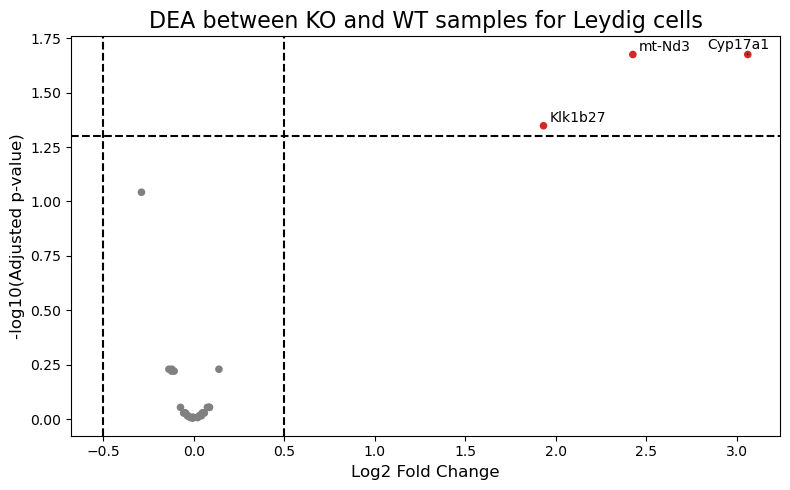

significantly DE genes for  Leydig cells , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.01 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   15.991813        0.494481  0.741509  0.666858  0.504863  0.673151
1   17.273909        1.675505  0.734760  2.280345  0.022587  0.090349
2   54.206953        0.361678  0.682981  0.529558  0.596419  0.745523
3   12.488924        1.105570  0.771612  1.432805  0.151914  0.379784
4   22.615174        0.898089  0.966860  0.928872  0.352956  0.588259
5   26.258293       -5.765011  1.596260 -3.611573  0.000304  0.006087
6   10.312560       -5.906954  2.492151 -2.370223  0.017777  0.090349
7   13.380209        0.859698  0.786180  1.093513  0.274169  0.517430
8   14.934078        0.854462  0.798508  1.070073  0.284586  0.517430
9   16.195459        2.687655  0.800570  3.357176  0.000787  0.007874
10   6.500067       -5.215456  2.491861 -2.092996  0.036350  0.121165
11  30.757527       -0.152073  0.675617 -0.225087  0.821911  0.865170
12  57.171072       -0.9149

Fitting MAP LFCs...
... done in 0.05 seconds.



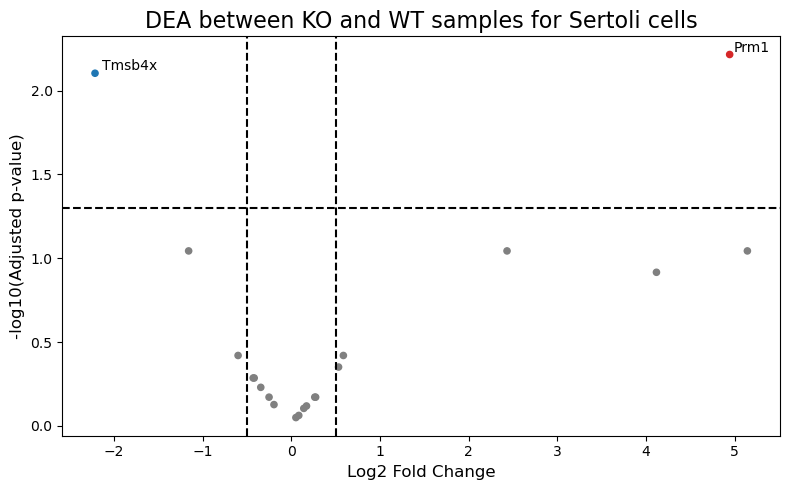

significantly DE genes for  Sertoli cells , intersected with bulk DEGs:
['Tmsb4x']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.22 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.19 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.03 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.421137       -0.602079  1.352919 -0.445022  0.656304  0.969801
1    10.388078       -1.514854  1.343650 -1.127417  0.259566  0.930283
2     7.577529       -1.349438  1.362798 -0.990197  0.322078  0.930283
3     7.549149       -0.900717  1.356103 -0.664195  0.506566  0.936631
4    27.676918       -1.904456  1.335228 -1.426315  0.153778  0.930283
..         ...             ...       ...       ...       ...       ...
97   15.647651       -0.203119  1.196167 -0.169808  0.865161  0.969801
98   11.859002        1.584343  1.216883  1.301968  0.192927  0.930283
99    6.036748       -1.661980  1.406590 -1.181567  0.237377  0.930283
100   3.937340       -1.833318  1.488255 -1.231857  0.218002  0.930283
101   5.658215       -0.652552  1.385259 -0.471069  0.637592  0.969801

[102 rows x 6 columns]


... done in 0.52 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.421137    3.635995e-07  0.001619 -0.445022  0.656304  0.969801
1    10.388078    8.883179e-07  0.001952 -1.127417  0.259566  0.930283
2     7.577529    7.837085e-07  0.001880 -0.990197  0.322078  0.930283
3     7.549149    5.703195e-07  0.001719 -0.664195  0.506566  0.936631
4    27.676918    1.010234e-06  0.002179 -1.426315  0.153778  0.930283
..         ...             ...       ...       ...       ...       ...
97   15.647651    1.565063e-07  0.001520 -0.169808  0.865161  0.969801
98   11.859002   -1.038482e-06  0.001242  1.301968  0.192927  0.930283
99    6.036748    8.975582e-07  0.001994 -1.181567  0.237377  0.930283
100   3.937340    8.154231e-07  0.002028 -1.231857  0.218002  0.930283
101   5.658215    3.806526e-07  0.001645 -0.471069  0.637592  0.969801

[102 rows x 6 columns]


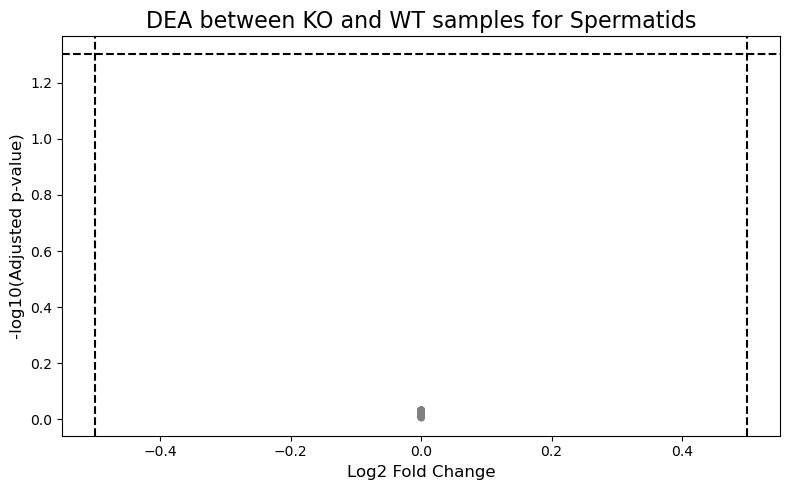

significantly DE genes for  Spermatids , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.45 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.03 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.64 seconds.

Fitting LFCs...
... done in 0.31 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting 

There is no KO or WT samples for this cell type
Using None as control genes, passed at DeseqDataSet initialization


... done in 0.06 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   19.238080        0.618937  1.135701  0.544982  0.585766  0.993457
1   41.061636       -0.553611  1.045335 -0.529602  0.596388  0.993457
2    8.447684        0.060456  1.160146  0.052111  0.958441  0.993457
3    7.029214        0.199632  1.213947  0.164449  0.869378  0.993457
4   10.853757       -0.038774  1.132253 -0.034245  0.972682  0.993457
5   15.507408        0.159947  1.100900  0.145288  0.884484  0.993457
6   16.412229        0.307570  1.107647  0.277679  0.781259  0.993457
7   15.291974        0.196265  1.104748  0.177656  0.858993  0.993457
8   20.833425       -0.211159  1.176871 -0.179424  0.857605  0.993457
9    8.186480       -0.024606  1.164715 -0.021127  0.983145  0.993457
10  13.725023       -0.202073  1.121557 -0.180172  0.857017  0.993457
11  40.106526       -0.295775  1.053097 -0.280862  0.778816  0.993457
12  30.114247       -7.3472

... done in 0.14 seconds.



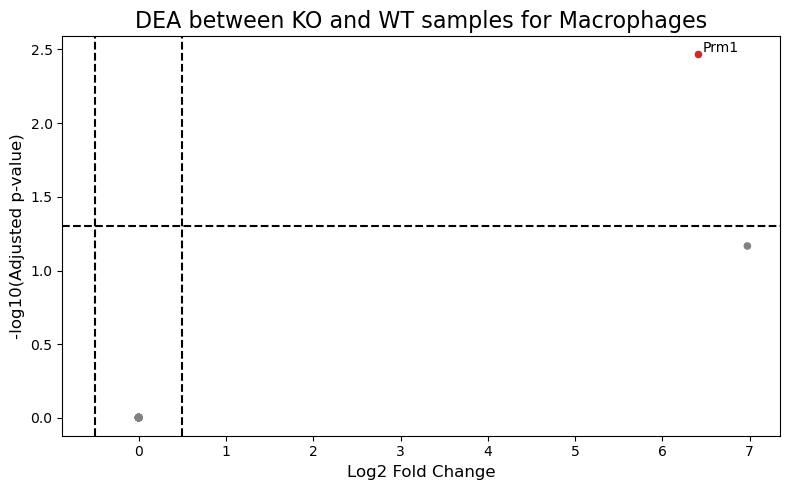

significantly DE genes for  Macrophages , intersected with bulk DEGs:
[]


In [34]:
for i in set(pdata.obs['joined_clust']):
    cell_type = pdata[pdata.obs['joined_clust'] == i].copy()
    genes = dc.filter_by_expr(cell_type, group='condition', min_count=10, min_total_count=15)

    # Filter by these genes
    cell_type = cell_type[:, genes].copy()
    cell_type.X = cell_type.X.round().astype(int)
    # Build DESeq2 object
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(
        counts=cell_type.X,
        metadata=cell_type.obs,
        design='~condition',
        refit_cooks=True,
        inference=inference,
    )
    # Compute LFCs
    dds.deseq2()

    if 'Knockout' not in set(dds.obs['condition']) or 'WT' not in set(dds.obs['condition']):
        print('There is no KO or WT samples for this cell type')
        continue
    
    # Extract contrast between KO and WT
    ds_KO_vs_WT = DeseqStats(
        dds,
        contrast=["condition", 'Knockout', 'WT'],
        inference=inference,
    )
    # Compute Wald test
    ds_KO_vs_WT.summary()
    ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
    results_df = ds_KO_vs_WT.results_df
    results_df.index = cell_type.var.index

    dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
        figsize=(8, 5)
    )

    title = 'DEA between KO and WT samples for ' + i
    plt.title(title, fontsize=16)
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(Adjusted p-value)', fontsize=12)
    
    plt.tight_layout()
    path = f'./pseudobulk_DEGs/mean_mode_all_stages{i}.png'
    plt.savefig(path, dpi=300)
    plt.show()

    
    significant = results_df[abs(results_df['padj']) < 0.05]
    singlecell = significant.index
    sc_bulk_intersection = list(set(singlecell) & set(bulk['x']))

    print('significantly DE genes for ', i, ', intersected with bulk DEGs:')
    print(sc_bulk_intersection)
    
    dict_to_save = {i: sc_bulk_intersection}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_bulk_intersected_DEGs_for_mean_mode_all_stages'+i+'.csv'
    df.to_csv(path, index=False)

    dict_to_save = {i: singlecell}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_DEGs_for_mean_mode_all_stages'+i+'.csv'
    df.to_csv(path, index=False)

## Testing

based on mode=sum

In [124]:
import os
import pickle as pkl

In [128]:
#cell_type.obs.to_csv('celltypeobs.csv')

In [131]:
#pd.DataFrame(cell_type.X).to_csv('celltypeX.csv', index=False)

In [135]:
#pd.DataFrame(cell_type.var.index).to_csv('genes.csv', index=False)

In [342]:
pdata

AnnData object with n_obs × n_vars = 44 × 26193
    obs: 'orig.ident', 'joined_clust', 'seurat_clusters', 'samples', 'condition', 'nCount_prediction.score.CellTypes', 'nFeature_prediction.score.CellTypes', 'active_ident', 'psbulk_n_cells', 'psbulk_counts'
    var: 'variable_gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'pca', 'orig.ident_colors', 'joined_clust_colors', 'pca_anova'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [280]:
genes

array(['Fau', 'Gm42418', 'Malat1', 'Rpl13', 'Rpl23', 'Rpl36', 'Rpl37',
       'Rpl37a', 'Rpl38', 'Rpl41', 'Rplp1', 'Rps20', 'Rps21', 'Rps24',
       'Rps27', 'Rps28', 'Rps29', 'Rps8', 'mt-Atp6', 'mt-Co1', 'mt-Co2',
       'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd4', 'mt-Nd4l'],
      dtype='<U15')

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.07 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

Fitting MAP dispersions...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.09 seconds.

Fitting LFCs...
... done in 0.04 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       57.435539       -0.286317  0.412966 -0.693320  4.881088e-01   
1      233.124329       -1.592126  0.659157 -2.415399  1.571800e-02   
2       43.536462       -0.288953  0.341998 -0.844896  3.981692e-01   
3       44.668929        0.625197  0.385011  1.623842  1.044094e-01   
4      144.717445       -0.766532  0.366822 -2.089654  3.664888e-02   
...           ...             ...       ...       ...           ...   
7492  2001.934872       -3.295267  0.374576 -8.797330  1.401098e-18   
7493  3976.173110       -0.497620  0.350358 -1.420321  1.555143e-01   
7494  3155.017529       -0.209704  0.383127 -0.547350  5.841384e-01   
7495  1804.323953       -0.420177  0.401081 -1.047611  2.948180e-01   
7496   451.721731       -0.400363  0.475392 -0.842174  3.996903e-01   

              padj  
0     7.907195e-01  
1     1.810519e-01  
2     7.375062e-01  


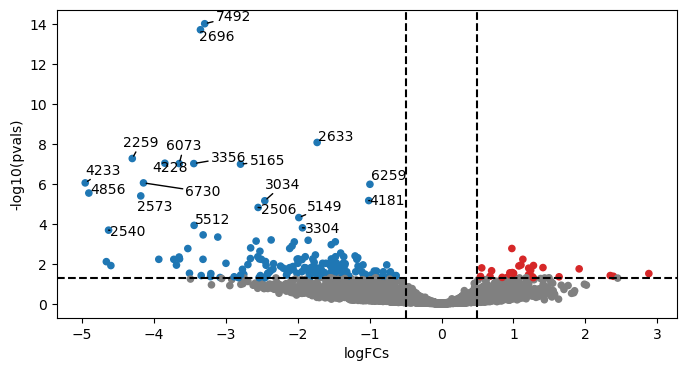

In [344]:
#For all cell types
#cell_type = pdata[pdata.obs['joined_clust'] == 'Leydig cells'].copy()
cell_type = pdata.copy()
genes = dc.filter_by_expr(cell_type, group='condition', min_count=10, min_total_count=15)

# Filter by these genes
cell_type = cell_type[:, genes].copy()

cell_type.X = cell_type.X.round().astype(int)
# Build DESeq2 object
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(
    counts=cell_type.X,
    metadata=cell_type.obs,
    design='~condition',
    refit_cooks=True,
    inference=inference,
)
# Compute LFCs
dds.deseq2()

# Compute Wald test
ds_KO_vs_WT.summary()

#ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")

results_df = ds_KO_vs_WT.results_df
#results_df.index = cell_type.var.index

dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)
significant = results_df[abs(results_df['padj']) < 0.05]
singlecell = significant.index
sc_bulk_intersection = list(set(singlecell) & set(bulk['x']))

In [291]:
test = pd.DataFrame(cell_type.X)

test.columns = cell_type.var.index

test.index = dds.obs['condition']

test['clust'] = pd.factorize(dds.obs['joined_clust'])[0]
factorization = pd.DataFrame(list(dds.obs['joined_clust']), pd.factorize(dds.obs['joined_clust'])[0])

counter = 0
colors = [
    'red', 'blue', 'green', 'yellow', 'orange', 'purple', 
    'pink', 'brown', 'gray', 'cyan', 'magenta', 'lime'
]

for i in set(test['clust']):
    # x = test[(test.index == 'WT') & (test['clust'] == i)]
    x = test.loc[(test.index == 'WT') & (test['clust'] == i)].mean()
    y = test.loc[(test.index == 'Knockout') & (test['clust'] == i)].mean()
    
    # Check if x and y have the same size
    if len(x) != len(y):
        print(f"Skipping cell type {factorization.loc[factorization.index == i]} because WT and Knockout samples have different sizes.")
        continue
    
    plt.scatter(x, y, color=colors[counter], s=0.1, label=f"Cluster {factorization.loc[factorization.index == i].iloc[0][0]}")
    counter += 1

# Change the limits of the x and y axes
plt.xlim(0, 1000)  # Set the x-axis limits
plt.ylim(0, 1000)  # Set the y-axis limits

plt.xlabel('WT')
plt.ylabel('Knockout')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=15)
plt.show()

In [292]:
test.columns = cell_type.var.index

In [293]:
test.index = dds.obs['condition']

In [294]:
test['clust'] = pd.factorize(dds.obs['joined_clust'])[0]
factorization = pd.DataFrame(list(dds.obs['joined_clust']), pd.factorize(dds.obs['joined_clust'])[0])

In [304]:
# test[test['clust'] == 0]

# test[test.index == 'WT']
test.loc[(test.index == 'WT') & (test['clust'] == 0)].mean()

0610009B22Rik      23.5
0610009L18Rik      47.5
0610010F05Rik      31.5
0610010K14Rik      39.0
0610012G03Rik      34.0
                  ...  
mt-Nd4           2805.5
mt-Nd4l          1715.5
mt-Nd5            894.0
mt-Nd6            162.5
clust               0.0
Length: 7498, dtype: float64

In [300]:
# test[test['clust'] == 0]

# test[test.index == 'WT']
test.loc[test[test.index == 'WT']].mean()

0610009B22Rik  0610009L18Rik  0610010F05Rik  0610010K14Rik  \
condition                                                               
WT                    16             54             32             42   
WT                    31             41             31             36   
Knockout              90             67             81            139   
Knockout              94             22            124            204   

           0610012G03Rik  0610030E20Rik  0610040B10Rik  1110004F10Rik  \
condition                                                               
WT                    31             33             29            331   
WT                    37             26             28            260   
Knockout              69             92             73            690   
Knockout              73             78             86            497   

           1110008P14Rik  1110017D15Rik  1110032A03Rik  1110038B12Rik  \
condition                                                               
WT                     9             13             74             27   
WT                    17             20             97             17   
Knockout              45             28            117             91   
Knockout              51             10            113             72   

           1110038F14Rik  1110051M20Rik  1110059E24Rik  1110059G10Rik  \
condition                                                               
WT                    49             37             22             39   
WT                    61             32             30             40   
Knockout             144            110             62            144   
Knockout             133            147             74            209   

           1110065P20Rik  1190007I07Rik  1300002E11Rik  1500009L16Rik  \
condition                                                               
WT                    58             20              9             11   
WT                    61             20              3             16   
Knockout             186             88             36             81   
Knockout             229             90             39             12   

           1500011B03Rik  1600012H06Rik  1600020E01Rik  1700001L05Rik  \
condition                                                               
WT                    29              7             24            359   
WT                    29             11             23            330   
Knockout             150             25             63            760   
Knockout             122             39             39            584   

           1700001O22Rik  1700003E16Rik  1700003F12Rik  1700006J14Rik  \
condition                                                               
WT                    19             90              4             47   
WT                    18             60              0             32   
Knockout               6             48              0            126   
Knockout               1             21              6             41   

           1700007L15Rik  1700008J07Rik  1700008K24Rik  1700010B08Rik  \
condition                                                               
WT                    27             35            108             50   
WT                    30             32             76             47   
Knockout             103             33            184             39   
Knockout             100             36             50             18   

           1700010I14Rik  1700010K23Rik  1700011M02Rik  1700012B09Rik  \
condition                                                               
WT                    85             47             18             32   
WT                   101             22             33             42   
Knockout             165              0            123             61   
Knockout              47              0             13             14   

           1700012D14Rik  1700016K05Rik  1700016K19Rik  1700

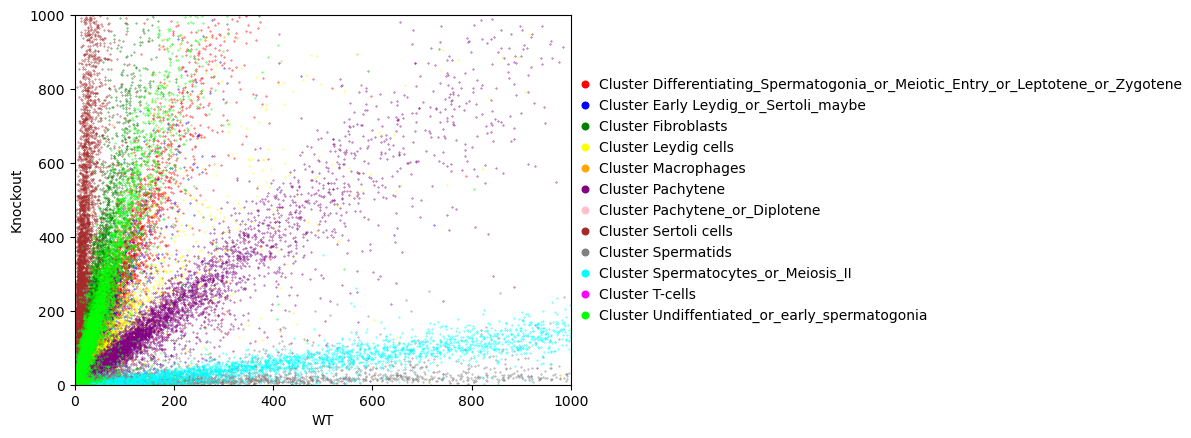

In [305]:
counter = 0
colors = [
    'red', 'blue', 'green', 'yellow', 'orange', 'purple', 
    'pink', 'brown', 'gray', 'cyan', 'magenta', 'lime'
]

for i in set(test['clust']):
    # x = test[(test.index == 'WT') & (test['clust'] == i)]
    x = test.loc[(test.index == 'WT') & (test['clust'] == i)].mean()
    y = test.loc[(test.index == 'Knockout') & (test['clust'] == i)].mean()
    
    # Check if x and y have the same size
    if len(x) != len(y):
        print(f"Skipping cell type {factorization.loc[factorization.index == i]} because WT and Knockout samples have different sizes.")
        continue
    
    plt.scatter(x, y, color=colors[counter], s=0.1, label=f"Cluster {factorization.loc[factorization.index == i].iloc[0][0]}")
    counter += 1

# Change the limits of the x and y axes
plt.xlim(0, 1000)  # Set the x-axis limits
plt.ylim(0, 1000)  # Set the y-axis limits

plt.xlabel('WT')
plt.ylabel('Knockout')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=15)
plt.show()

based on mode=mean

In [324]:
cell_type

AnnData object with n_obs × n_vars = 44 × 26193
    obs: 'orig.ident', 'joined_clust', 'seurat_clusters', 'samples', 'condition', 'nCount_prediction.score.CellTypes', 'nFeature_prediction.score.CellTypes', 'active_ident', 'psbulk_n_cells', 'psbulk_counts'
    var: 'variable_gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'pca', 'orig.ident_colors', 'joined_clust_colors', 'pca_anova'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

Fitting size factors...
... done in 0.07 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 18.73 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 25.47 seconds.

Fitting LFCs...
... done in 27.35 seconds.

Calculating cook's distance...
... done in 0.08 seconds.

Replacing 161 outlier genes.

Fitting dispersions...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 0.33 seconds.

Fitting LFCs...
... done in 0.65 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       57.435539       -0.286317  0.412966 -0.693320  4.881088e-01   
1      233.124329       -1.592126  0.659157 -2.415399  1.571800e-02   
2       43.536462       -0.288953  0.341998 -0.844896  3.981692e-01   
3       44.668929        0.625197  0.385011  1.623842  1.044094e-01   
4      144.717445       -0.766532  0.366822 -2.089654  3.664888e-02   
...           ...             ...       ...       ...           ...   
7492  2001.934872       -3.295267  0.374576 -8.797330  1.401098e-18   
7493  3976.173110       -0.497620  0.350358 -1.420321  1.555143e-01   
7494  3155.017529       -0.209704  0.383127 -0.547350  5.841384e-01   
7495  1804.323953       -0.420177  0.401081 -1.047611  2.948180e-01   
7496   451.721731       -0.400363  0.475392 -0.842174  3.996903e-01   

              padj  
0     7.907195e-01  
1     1.810519e-01  
2     7.375062e-01  


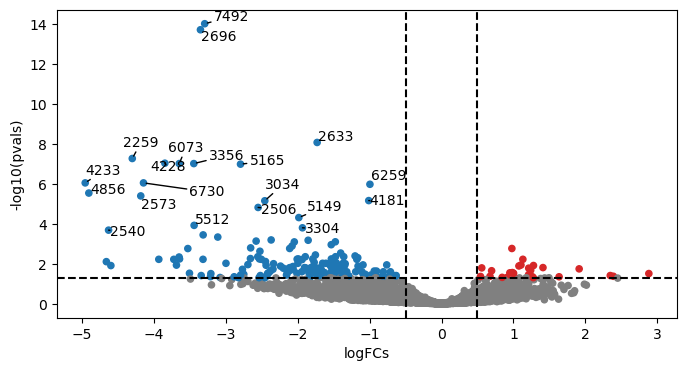

In [325]:
#For all cell types
#cell_type = pdata[pdata.obs['joined_clust'] == 'Leydig cells'].copy()
cell_type = pdata.copy()
#genes = dc.filter_by_expr(cell_type, group='condition') #, min_count=10, min_total_count=15)

# Filter by these genes
#cell_type = cell_type[:, genes].copy()

cell_type.X = cell_type.X.round().astype(int)
# Build DESeq2 object
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(
    counts=cell_type.X,
    metadata=cell_type.obs,
    design='~condition',
    refit_cooks=True,
    inference=inference,
)
# Compute LFCs
dds.deseq2()

# Compute Wald test
ds_KO_vs_WT.summary()

#ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")

results_df = ds_KO_vs_WT.results_df
#results_df.index = cell_type.var.index

dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)
significant = results_df[abs(results_df['padj']) < 0.05]
singlecell = significant.index
sc_bulk_intersection = list(set(singlecell) & set(bulk['x']))

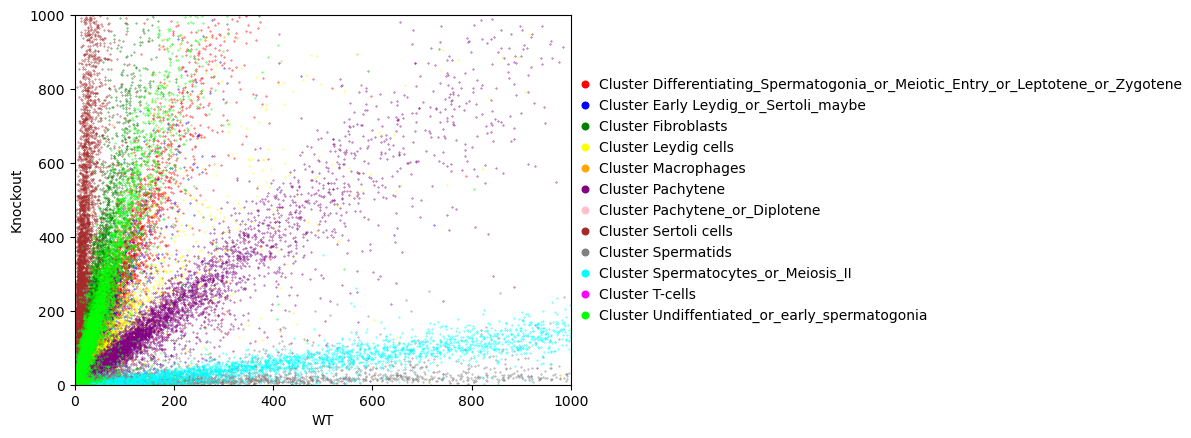

In [326]:
counter = 0
colors = [
    'red', 'blue', 'green', 'yellow', 'orange', 'purple', 
    'pink', 'brown', 'gray', 'cyan', 'magenta', 'lime'
]

for i in set(test['clust']):
    # x = test[(test.index == 'WT') & (test['clust'] == i)]
    x = test.loc[(test.index == 'WT') & (test['clust'] == i)].mean()
    y = test.loc[(test.index == 'Knockout') & (test['clust'] == i)].mean()
    
    # Check if x and y have the same size
    if len(x) != len(y):
        print(f"Skipping cell type {factorization.loc[factorization.index == i]} because WT and Knockout samples have different sizes.")
        continue
    
    plt.scatter(x, y, color=colors[counter], s=0.1, label=f"Cluster {factorization.loc[factorization.index == i].iloc[0][0]}")
    counter += 1

# Change the limits of the x and y axes
plt.xlim(0, 1000)  # Set the x-axis limits
plt.ylim(0, 1000)  # Set the y-axis limits

plt.xlabel('WT')
plt.ylabel('Knockout')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=15)
plt.show()

In [90]:
# Extract matrix and row names
normed_counts = dds.layers['normed_counts']
rownames = dds.obs['condition']
colnames = cell_type.var.index

pd.set_option('display.max_columns', None) 
# Convert to DataFrame
pd.DataFrame(normed_counts, index=rownames, columns=colnames)

0610009B22Rik  0610009L18Rik  0610010F05Rik  0610010K14Rik  \
condition                                                               
WT             26.575319      13.287660       5.536525      27.682624   
WT             22.370644      14.913763      14.913763      28.336149   
Knockout       23.676913      10.147248      10.147248      32.132953   
Knockout       29.141514       4.066258       8.810225      29.819224   

           0610012G03Rik  0610030E20Rik  1110004F10Rik  1110008P14Rik  \
condition                                                               
WT             50.936028      33.219149     147.271559     602.373897   
WT             79.042943      13.422387     110.361845     873.946502   
Knockout       52.427450      16.066477     108.237316     547.105806   
Knockout       63.704705      22.364418      78.614317     255.496530   

           1110012L19Rik  1110017D15Rik  1110032A03Rik  1110038B12Rik  \
condition                                                               
WT              5.536525      33.219149      47.614113      34.326454   
WT             17.896515      14.913763      38.775783      17.896515   
Knockout       14.375268       0.000000      21.140101      28.750537   
Knockout       14.909612       0.000000      32.530062      20.331289   

           1110038F14Rik  1110046J04Rik  1110051M20Rik  1110059E24Rik  \
condition                                                               
WT             29.897234      12.180355      15.502269      21.038794   
WT             28.336149       2.982753      13.422387      19.387892   
Knockout       14.375268      11.838456      14.375268      10.992852   
Knockout       21.686708      18.298160      16.265031      15.587321   

           1110059G10Rik  1110065P20Rik  1190007I07Rik  1300002E11Rik  \
condition                                                               
WT             24.360709      44.292198       9.965745      26.575319   
WT             14.913763      47.724041      13.422387      22.370644   
Knockout       20.294497      32.978557      21.985705      10.147248   
Knockout       18.975870      29.141514      27.108385      11.521064   

           1500004A13Rik  1500009L16Rik  1500011B03Rik  1600002K03Rik  \
condition                                                               
WT             12.180355      33.219149      48.721418      13.287660   
WT              2.982753      86.499824      73.077438      14.913763   
Knockout       10.147248      46.508222      38.897785       6.764832   
Knockout        2.710839      13.554193      27.108385       8.810225   

           1600012H06Rik  1600020E01Rik  1700001C19Rik  1700001O22Rik  \
condition                                                               
WT             15.502269      17.716879      87.477092      52.043333   
WT              7.456881       8.948258      20.879268      44.741289   
Knockout       10.992852       9.301644       0.000000       0.000000   
Knockout       10.843354       4.743967       0.000000       0.000000   

           1700003E16Rik  1700003F12Rik  1700009J07Rik  1700009N14Rik  \
condition                                                               
WT             11.073050     183.812623      23.253404     106.301276   
WT             13.422387      68.603309      10.439634      19.387892   
Knockout        0.000000       0.000000       0.000000       0.845604   
Knockout        0.000000       1.355419       0.000000       0.000000   

           1700011M02Rik  1700012A03Rik  1700013G24Rik  1700015G11Rik  \
condition                                                               
WT             24.360709      81.940567      21.038794     159.451914   
WT              0.000000      14.913763      19.387892      52.198170   
Knockout       21.140101       0.000000       0.000000       0.000000   
Knockout        0.000000       0.000000       0.677710       0.000000   

           1700016C15Rik  1700016F12Rik  1700016H13Rik  1700

In [92]:
# Extract matrix and row names
normed_counts = dds.layers['normed_counts']
rownames = dds.obs['orig.ident']
colnames = cell_type.var.index

#pd.set_option('display.max_columns', None) 
# Convert to DataFrame
pd.DataFrame(normed_counts, index=rownames, columns=colnames)['Ass1']

orig.ident
IGB_1_InWork    378.698296
IGB_2_InWork    547.335096
IGB_3            14.375268
IGB_4             8.132516
Name: Ass1, dtype: float64

In [83]:
pdata.obs[pdata.obs['joined_clust'] == 'Macrophages']

orig.ident joined_clust seurat_clusters  \
IGB_1_InWork_Macrophages  IGB_1_InWork  Macrophages               7   
IGB_2_InWork_Macrophages  IGB_2_InWork  Macrophages               7   
IGB_3_Macrophages                IGB_3  Macrophages               7   
IGB_4_Macrophages                IGB_4  Macrophages               7   

                                    samples condition  \
IGB_1_InWork_Macrophages  IGB_1_il_10.21_13        WT   
IGB_2_InWork_Macrophages  IGB_2_il_10.22_13        WT   
IGB_3_Macrophages         IGB_3_il_10.23_13  Knockout   
IGB_4_Macrophages         IGB_4_il_10.24_13  Knockout   

                         nCount_prediction.score.CellTypes  \
IGB_1_InWork_Macrophages                                 0   
IGB_2_InWork_Macrophages                                 0   
IGB_3_Macrophages                                        0   
IGB_4_Macrophages                                        0   

                         nFeature_prediction.score.CellTypes active_ident  \
IGB_1_InWork_Macrophages                                   0  Macrophages   
IGB_2_InWork_Macrophages                                   0  Macrophages   
IGB_3_Macrophages                                          0  Macrophages   
IGB_4_Macrophages                                          0  Macrophages   

                          psbulk_n_cells  psbulk_counts  
IGB_1_InWork_Macrophages           102.0       179945.0  
IGB_2_InWork_Macrophages            73.0       167274.0  
IGB_3_Macrophages                  123.0       478179.0  
IGB_4_Macrophages                  157.0       470477.0